In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import get_samples
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork 
from cgan_versions import PearsonCGAN, KLCGAN, RKLCGAN, WCGAN, WdivCGAN
from cgan import CGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

In [2]:
# Heteroskedastic
def mean_func(x):
    return np.power(x,2) + 0.5

def std_dev_func(x):
    return np.power(np.sin(np.pi*x), 2) + 0.01

def sample(xs =np.random.uniform(low=0., high=1., size=1000)):
    n = len(xs)
    assert n == len(xs), 'noise length should be same as xs length'
    noise = np.random.normal(loc=0., scale=std_dev_func(xs), size=n)
    ys = mean_func(xs) + noise

    return np.stack((xs, ys), axis=1)

# 1D Probability density functions as python function objects
def get_gaussian_pdf(mean, std_dev):
    dist = torch.distributions.normal.Normal(mean, std_dev)
    return (lambda y: torch.exp(dist.log_prob(y)))
def get_pdf(x):
    return get_gaussian_pdf(mean_func(x), std_dev_func(x))

def get_support(x):
    mean = mean_func(x)
    std_dev = std_dev_func(x)
    return (mean-2*std_dev, mean+2*std_dev)

In [5]:
# Sampling from heteroskedastic 
n = 2000 #number of samples
x_samples = np.random.uniform(low=0, high=1, size=n)
combined = sample(x_samples)

In [6]:
combined_train, combined_validation = model_selection.train_test_split(combined, test_size=0.5, random_state=43)

scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(combined_train)
# Scale test data based on training data
val_set_scaled = scaler.transform(combined_validation)


# Test set for W evaluation
tmp = np.random.choice(len(combined_validation),50, replace=False)
x_samples_test_repeated = np.repeat(combined_validation[tmp,0], repeats=200, axis = 0)
x_samples_test_repeated = x_samples_test_repeated.reshape((len(x_samples_test_repeated,)))
combined_test = sample(x_samples_test_repeated)
test_set_scaled = scaler.transform(combined_test)

# plt.figure()
# plt.scatter(val_set_scaled[:,0],val_set_scaled[:,1], s=0.3, color='k')

In [7]:
# Make sure that heteroskedastic set from above corresponds to data imported below

#export data
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'

# preprocessing folder
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

if not os.path.exists(raw_dataset_path):
    os.makedirs(raw_dataset_path)


# raw data
np.savetxt("./{}/{}/raw_data/train.csv".format(DATASET_PATH,DATASET_NAME), combined_train,delimiter=",")
np.savetxt("./{}/{}/raw_data/val.csv".format(DATASET_PATH,DATASET_NAME), combined_validation,delimiter=",")
np.savetxt("./{}/{}/raw_data/test.csv".format(DATASET_PATH,DATASET_NAME), combined_test,delimiter=",")


np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), train_set_scaled,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), val_set_scaled,delimiter=",")
np.savetxt("./{}/{}/test.csv".format(DATASET_PATH,DATASET_NAME), test_set_scaled,delimiter=",")


In [8]:
tmp = np.random.choice(len(combined_validation),50, replace=False)
x_samples_train_repeated = np.repeat(combined_train[tmp,:-1], repeats=200, axis = 0)
x_samples_train_repeated = x_samples_train_repeated.reshape((len(x_samples_train_repeated,)))
combined_train_repeated = sample(x_samples_train_repeated)
train_set_repeated_scaled = scaler.transform(combined_train_repeated)
np.savetxt("./{}/train_repeated.csv".format(raw_dataset_path), combined_train_repeated,delimiter=",")
np.savetxt("./{}/{}/train_repeated.csv".format(DATASET_PATH,DATASET_NAME), train_set_repeated_scaled,delimiter=",")


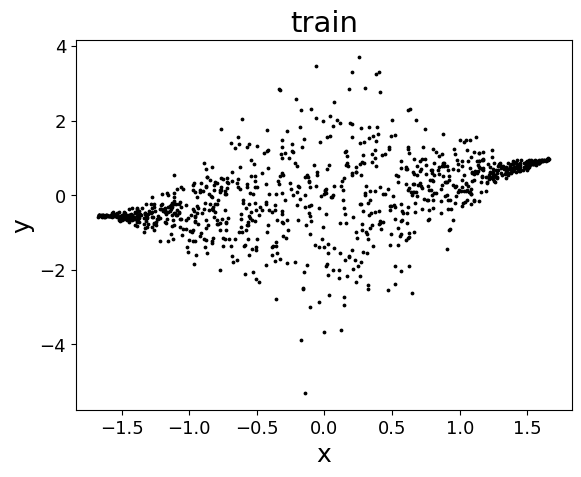

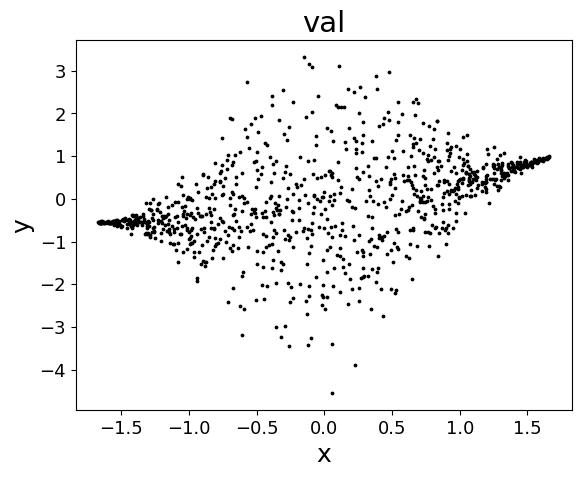

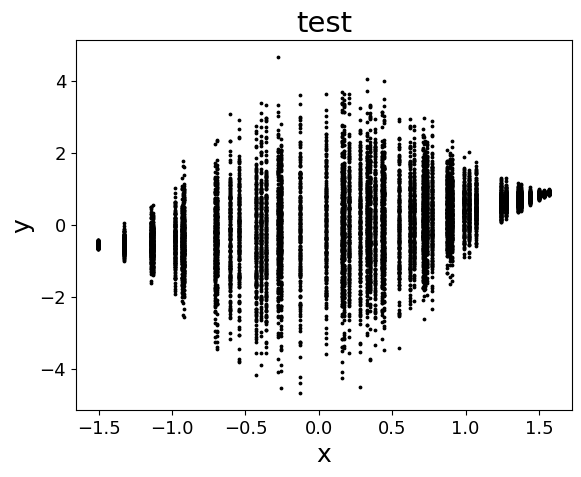

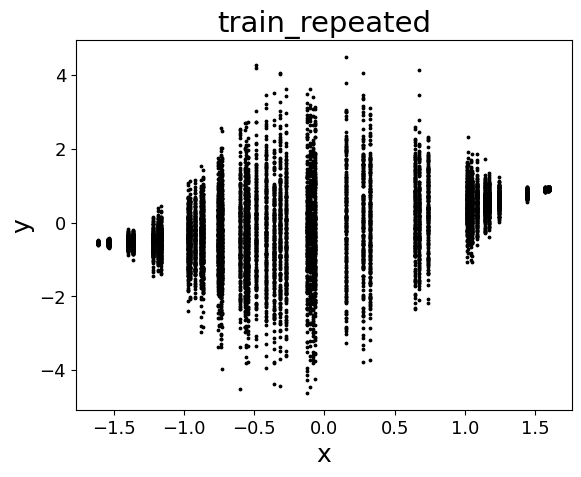

In [3]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 1
Y_DIM = 1
scatter_plot = 1

for split in ("train","val","test","train_repeated"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        save_path = os.path.join("./plots", DATASET_NAME)
        plt.savefig('{}/{}.png'.format(save_path,split))
        plt.show()
        plt.close()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']
train_data_repeated = splits['train_repeated']

In [4]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data_val = val_data, data_train = train_data,
                                data_test = test_data, data_train_repeated = train_data_repeated, epoch = epoch)

In [22]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = 'heteroskedastic_WCGAN'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = 'heteroskedastic'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [21]:
# config for WCGAN
config = {
    "noise_dim": 5,
    "epochs": 5000,
    "batch_size": 200,
    "gen_lr": 3e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":None,
    "scatter": 1,
    "kde_batch_size": 15,
    "n_critic": 5,
    "lambda_gp": 2e-2,
    'one-sided': True
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64,64,64,64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "batch_norm": None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64,64,64,64],
    # "cond_layers": [64,64],
    # "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "batch_norm": None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}

cgan_model = WCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

Epoch 19, true	ll: -1.967	mae: 1.3492	Wasserstein-1 dist: 0.77726	Wasserstein-2 dist: 0.85092
Epoch 39, true	ll: -1.6877	mae: 1.1017	Wasserstein-1 dist: 0.55523	Wasserstein-2 dist: 0.66474
Epoch 59, true	ll: -1.4453	mae: 0.70633	Wasserstein-1 dist: 0.396	Wasserstein-2 dist: 0.6035
Epoch 79, true	ll: -1.4088	mae: 0.66884	Wasserstein-1 dist: 0.23356	Wasserstein-2 dist: 0.42733
Epoch 99, true	ll: -1.5721	mae: 0.71092	Wasserstein-1 dist: 0.424	Wasserstein-2 dist: 0.52637
Epoch 119, true	ll: -1.3611	mae: 0.66401	Wasserstein-1 dist: 0.1445	Wasserstein-2 dist: 0.31547
Epoch 139, true	ll: -1.3688	mae: 0.7318	Wasserstein-1 dist: 0.16287	Wasserstein-2 dist: 0.26444
Epoch 159, true	ll: -1.3556	mae: 0.68896	Wasserstein-1 dist: 0.16875	Wasserstein-2 dist: 0.25046
Epoch 179, true	ll: -1.2712	mae: 0.67158	Wasserstein-1 dist: 0.13927	Wasserstein-2 dist: 0.20073
Epoch 199, true	ll: -1.1699	mae: 0.6453	Wasserstein-1 dist: 0.10541	Wasserstein-2 dist: 0.17127
Epoch 219, true	ll: -1.114	mae: 0.67071	Wasser

KeyboardInterrupt: 

In [67]:
tmp = test_data.x[-200:]
tmp = tmp.repeat_interleave(2, dim=0)
real = test_data.y[-200:]
fake = cgan_model.sample(tmp)
real_mean = torch.mean(real)
import ot
dist = ot.wasserstein_1d(real, fake, p = 1)/real_mean

Epoch 19, true	ll: -1.4796	mae: 0.68362	Wasserstein-1 dist: 0.21262	Wasserstein-2 dist: 0.26599
Epoch 39, true	ll: -1.3819	mae: 0.65097	Wasserstein-1 dist: 0.31387	Wasserstein-2 dist: 0.48994
Epoch 59, true	ll: -1.3888	mae: 0.63607	Wasserstein-1 dist: 0.38772	Wasserstein-2 dist: 0.53251
Epoch 79, true	ll: -1.2954	mae: 0.65693	Wasserstein-1 dist: 0.16858	Wasserstein-2 dist: 0.26704
Epoch 99, true	ll: -1.3093	mae: 0.68439	Wasserstein-1 dist: 0.29954	Wasserstein-2 dist: 0.36234
Epoch 119, true	ll: -1.1877	mae: 0.65525	Wasserstein-1 dist: 0.12837	Wasserstein-2 dist: 0.1716
Epoch 139, true	ll: -1.184	mae: 0.6624	Wasserstein-1 dist: 0.22173	Wasserstein-2 dist: 0.275
Epoch 159, true	ll: -1.1085	mae: 0.64394	Wasserstein-1 dist: 0.086575	Wasserstein-2 dist: 0.12447
Epoch 179, true	ll: -1.0626	mae: 0.63508	Wasserstein-1 dist: 0.11369	Wasserstein-2 dist: 0.14205
Epoch 199, true	ll: -1.0483	mae: 0.63093	Wasserstein-1 dist: 0.058513	Wasserstein-2 dist: 0.071287
Epoch 219, true	ll: -1.0334	mae: 0.63

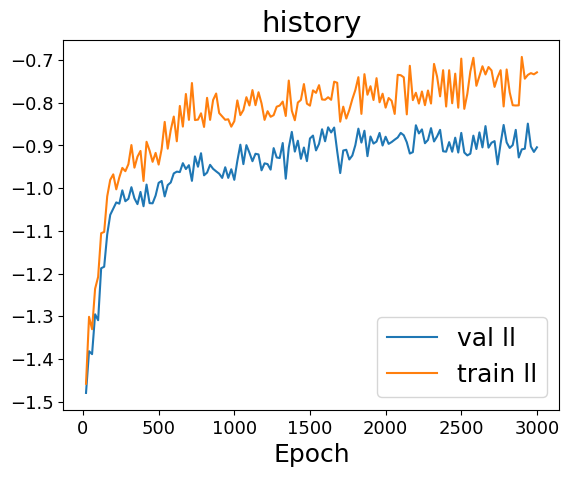

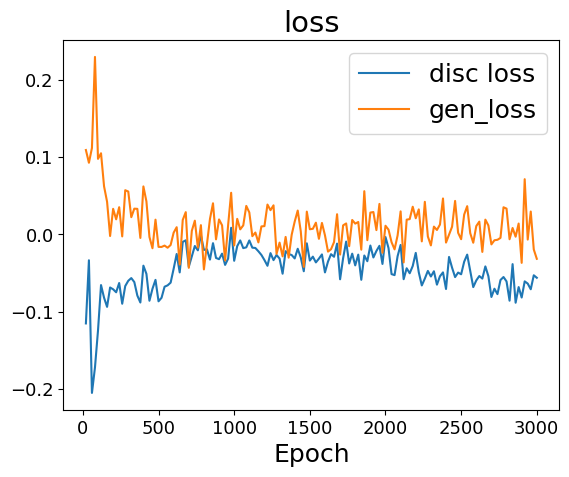

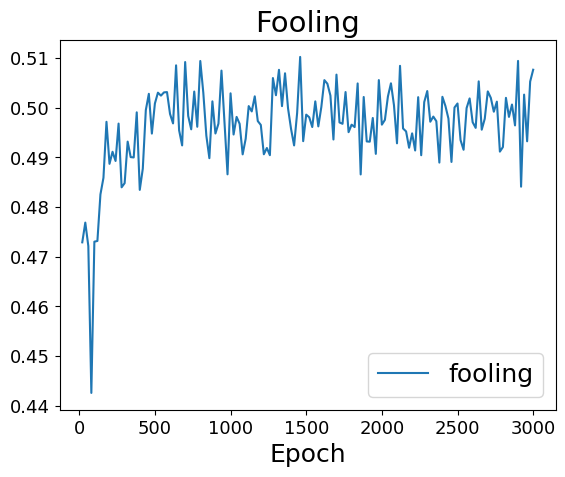

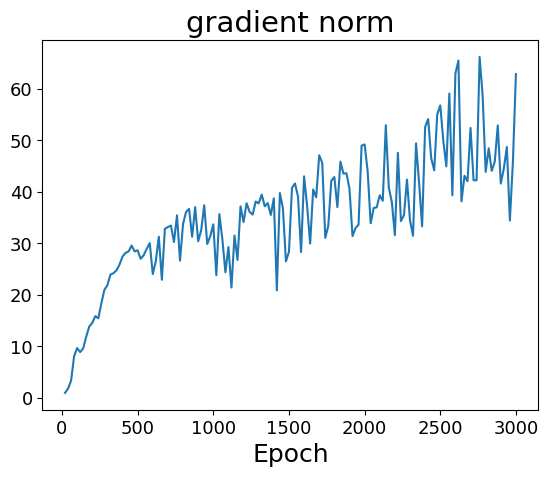

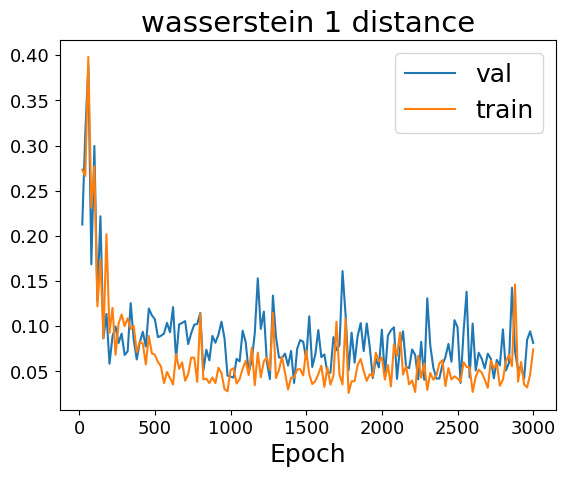

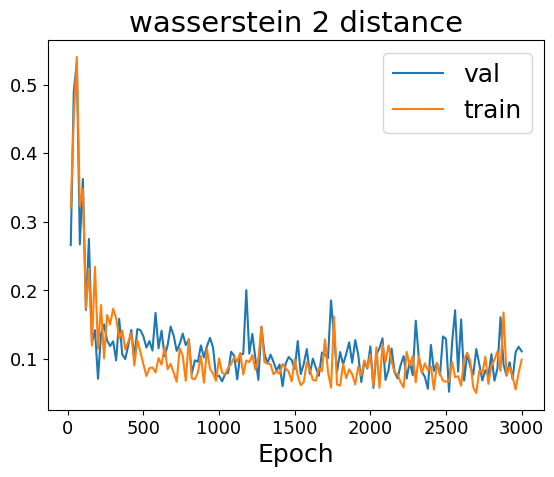

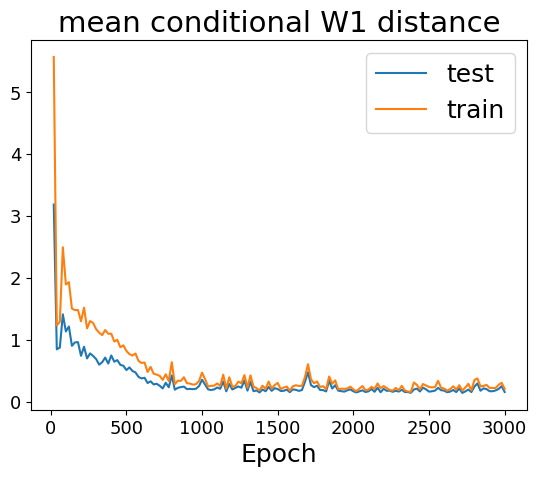

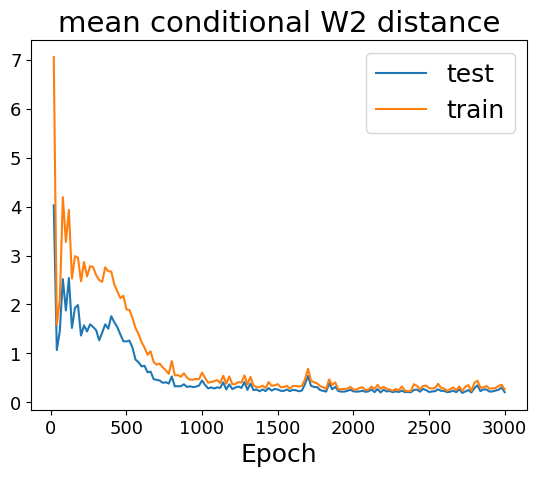

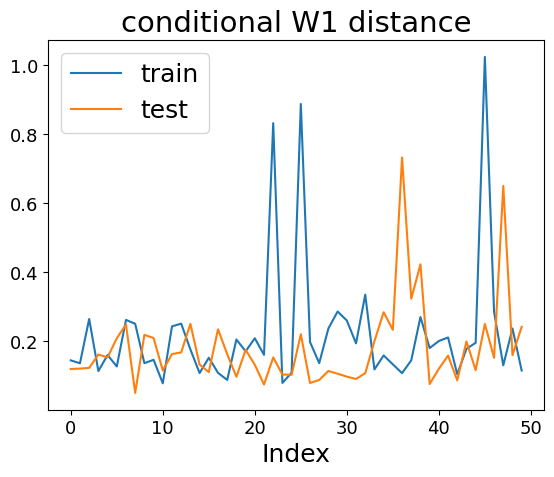

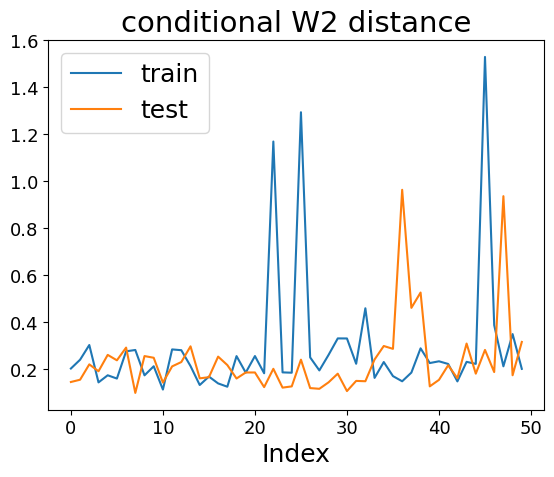

In [23]:
# #create nn spec for discriminator and generator
config = {
    "noise_dim": 5,
    "epochs": 3000,
    "batch_size": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":0,
    "scatter": 1,
    "kde_batch_size": 10,
}

nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": NoiseInjection,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": DoubleInputNetwork,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}
cgan_model = PearsonCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [61]:
## Comparsion between conditional pdf of real and generated samples
DATASET_PATH = './datasets'
DATASET_NAME = 'heteroskedastic'
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

for split in ('train','test','val'):
    data_path = os.path.join(raw_dataset_path,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    data = np.genfromtxt(data_path,delimiter=",")

    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data_raw = splits["train"]

y_train_mean = torch.mean(train_data_raw.y).item()
y_train_std = torch.std(train_data_raw.y).item()

x_train_std = torch.std(train_data_raw.x).item()
x_train_mean = torch.mean(train_data_raw.x).item()

In [75]:
best_save_path = os.path.join(cgan_model.param_dir,
                            "epoch_best.pt") # Path to save best params to
checkpoint = torch.load(best_save_path, map_location=cgan_model.device)
# checkpoint = torch.load(best_save_path)
if "gen" in checkpoint:
    cgan_model.gen.load_state_dict(checkpoint["gen"])
cgan_model.disc.load_state_dict(checkpoint["disc"])

<All keys matched successfully>

0.5631245606422425


Text(0.5, 1.0, 'x=0.2048')

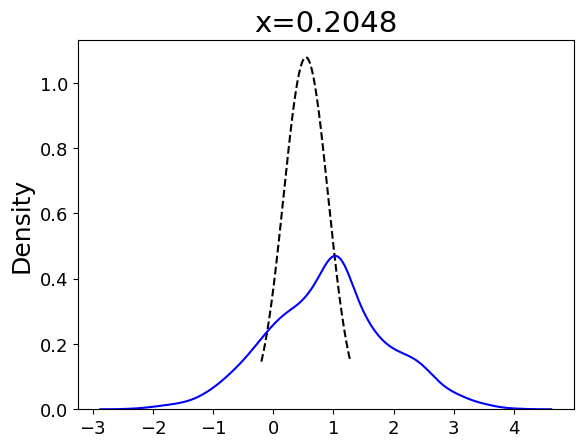

In [76]:
# generated samples
x0 = 0.2048
print(x0*x_train_std+x_train_mean)
y_gen = get_samples(cgan_model,x0, num_samples=3000).numpy()
y_gen = y_gen*y_train_std+y_train_mean

# real pdf
real_pdf = get_pdf(x0)
supp = get_support(x0)
real_pdf_xs = torch.linspace(supp[0], supp[1], steps = 1000)
real_pdf_ys = real_pdf(real_pdf_xs)

plt.figure()
plt.plot(real_pdf_xs, real_pdf_ys, color ='k', linestyle='--',label='x={}'.format(x0))
sns.kdeplot(y_gen.squeeze(),color='b')
plt.title('x={}'.format(x0))


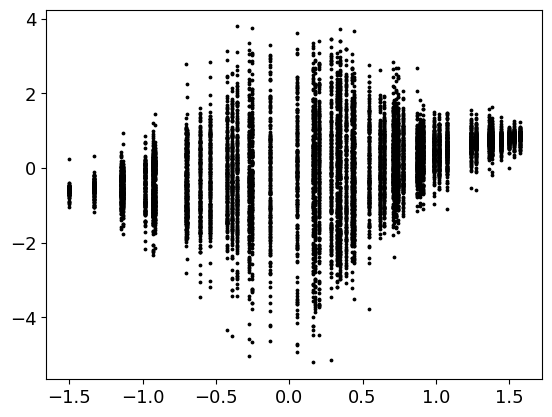

In [56]:
tmp = cgan_model.sample(test_data.x)
plt.scatter(test_data.x, tmp, s = 3, color ='k')


In [50]:
# tmp = checkpoint['gen']
# for key,_ in tmp.items():
#     print(key)

# print(len(tmp['layers.1.weight']))

Post-process

Text(0.5, 0, 'Epochs')

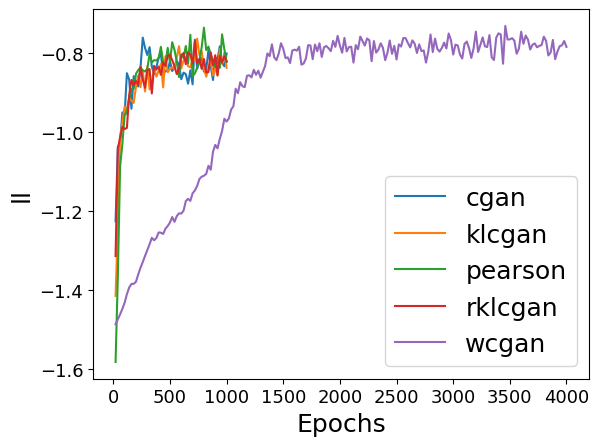

In [62]:
path = os.path.join('postprocess','heteroskedastic','ll.csv')
tmp = pd.read_csv(path, delimiter=',')
plt.figure()
for model in ('cgan', "klcgan", "pearson","rklcgan"):
    plt.plot(tmp['epoch'],tmp[model], label=model)
plt.plot(tmp['epoch.1'],tmp['wcgan'], label = 'wcgan')
plt.legend()
plt.ylabel("ll")
plt.xlabel('Epochs')
# plt.figure()
# plt.plot(tmp[:,0],tmp)